<a href="https://colab.research.google.com/github/Reaper-ai/brain-tumor-CSRE/blob/main/notebooks/btcs_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor MRI Classification using Deep Learning

This project uses a Convolutional Neural Network (CNN) to classify MRI brain scan images into multiple tumor types. The model is trained using the **Brain Tumor Dataset** from Kaggle and is designed for deployment in clinical aid tools.

### Objective
To classify MRI images of the brain into:
- Glioma Tumor
- Meningioma Tumor
- Pituitary Tumor
- No Tumor

We use **transfer learning with MobileNetV2** for efficient classification, aiming for both accuracy and lightweight deployment.

---


**Download dataset**

In [1]:
from google.colab import files
files.upload()  # upload kaggle.json

# Move to kaggle folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI and download dataset
!pip install -q kaggle
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip -d data/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 60% 89.0M/149M [00:00<00:00, 930MB/s]
100% 149M/149M [00:00<00:00, 715MB/s] 


**Imports**

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import zipfile

**Extract data**

In [3]:
zip_path = "/content/brain-tumor-mri-dataset.zip"
extract_path = "/data/brain_tumor_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Dataset extracted to: /data/brain_tumor_dataset


## Preprocessing Pipeline

We apply the following transforms to the MRI images:
- Resize to 224x224
- Convert to tensor
- Normalize using ImageNet statistics (for transfer learning with pretrained models)


In [6]:
train_dir = 'data/Training'
test_dir = 'data/Testing'
img_size = 224
batch_size = 32

# Define transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Train-validation split
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


## Dataset Overview

The dataset consists of brain MRI images categorized into four classes:
- Glioma Tumor
- Meningioma Tumor
- Pituitary Tumor
- No Tumor

Each class contains MRI slices stored in folders. We'll use PyTorch's `ImageFolder` to load and analyze the dataset structure.


In [12]:
from collections import Counter

train_classes = train_dataset.classes
class_counts = Counter([label for _, label in train_dataset.imgs])

print("Number of samples per class:")
for i, cls in enumerate(train_classes):
    print(f"{cls}: {class_counts[i]} samples")


Number of samples per class:
glioma: 1321 samples
meningioma: 1339 samples
notumor: 1595 samples
pituitary: 1457 samples


## Sample Images from Each Class

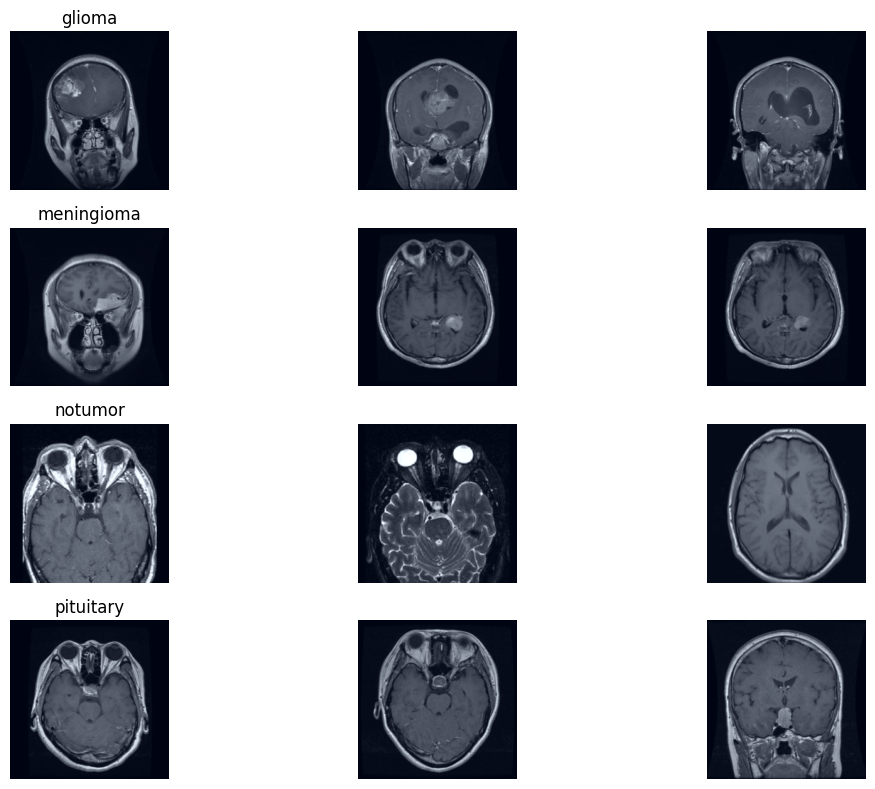

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples_per_class(dataset, class_names, samples_per_class=3):
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(12, 8))
    seen = {cls: 0 for cls in range(len(class_names))}

    for img, label in dataset:
        if seen[label] < samples_per_class:
            ax = axes[label][seen[label]]
            img_np = img.permute(1, 2, 0).numpy()
            img_np = (img_np * 0.229 + 0.485)  # unnormalize for visualization
            img_np = np.clip(img_np, 0, 1)
            ax.imshow(img_np)
            ax.axis('off')
            if seen[label] == 0:
                ax.set_title(class_names[label])
            seen[label] += 1
        if all(seen[l] >= samples_per_class for l in seen):
            break
    plt.tight_layout()
    plt.show()

show_samples_per_class(train_dataset, train_classes)

## Model Architecture: MobileNetV2

We use **MobileNetV2**, a lightweight CNN pretrained on ImageNet. It's ideal for mobile and web deployment due to:
- Fewer parameters than ResNet or VGG
- High accuracy on small medical datasets
- Faster inference speed

We replace the final layer to adapt it to our 4-class classification task.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 4)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 195MB/s]


**Training**

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_accuracy = correct / total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_accuracy = val_correct / val_total

    # Append metrics
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")


100%|██████████| 179/179 [00:47<00:00,  3.80it/s]


Epoch 1/10 | Train Loss: 0.0086, Train Acc: 0.9977 | Val Loss: 0.0438, Val Acc: 0.9870


100%|██████████| 179/179 [00:46<00:00,  3.85it/s]


Epoch 2/10 | Train Loss: 0.0250, Train Acc: 0.9916 | Val Loss: 0.1037, Val Acc: 0.9695


100%|██████████| 179/179 [00:46<00:00,  3.84it/s]


Epoch 3/10 | Train Loss: 0.0116, Train Acc: 0.9961 | Val Loss: 0.0384, Val Acc: 0.9908


100%|██████████| 179/179 [00:46<00:00,  3.84it/s]


Epoch 4/10 | Train Loss: 0.0115, Train Acc: 0.9954 | Val Loss: 0.0517, Val Acc: 0.9878


100%|██████████| 179/179 [00:46<00:00,  3.88it/s]


Epoch 5/10 | Train Loss: 0.0034, Train Acc: 0.9991 | Val Loss: 0.0358, Val Acc: 0.9901


100%|██████████| 179/179 [00:46<00:00,  3.84it/s]


Epoch 6/10 | Train Loss: 0.0040, Train Acc: 0.9986 | Val Loss: 0.0540, Val Acc: 0.9893


100%|██████████| 179/179 [00:46<00:00,  3.83it/s]


Epoch 7/10 | Train Loss: 0.0027, Train Acc: 0.9993 | Val Loss: 0.0482, Val Acc: 0.9901


100%|██████████| 179/179 [00:46<00:00,  3.88it/s]


Epoch 8/10 | Train Loss: 0.0029, Train Acc: 0.9989 | Val Loss: 0.0406, Val Acc: 0.9916


100%|██████████| 179/179 [00:46<00:00,  3.84it/s]


Epoch 9/10 | Train Loss: 0.0057, Train Acc: 0.9981 | Val Loss: 0.0329, Val Acc: 0.9916


100%|██████████| 179/179 [00:46<00:00,  3.85it/s]


Epoch 10/10 | Train Loss: 0.0045, Train Acc: 0.9989 | Val Loss: 0.0430, Val Acc: 0.9893


**Save weights**

In [18]:
torch.save(model.state_dict(), "brain_tumor_classifier.pth")

**Evaluation**



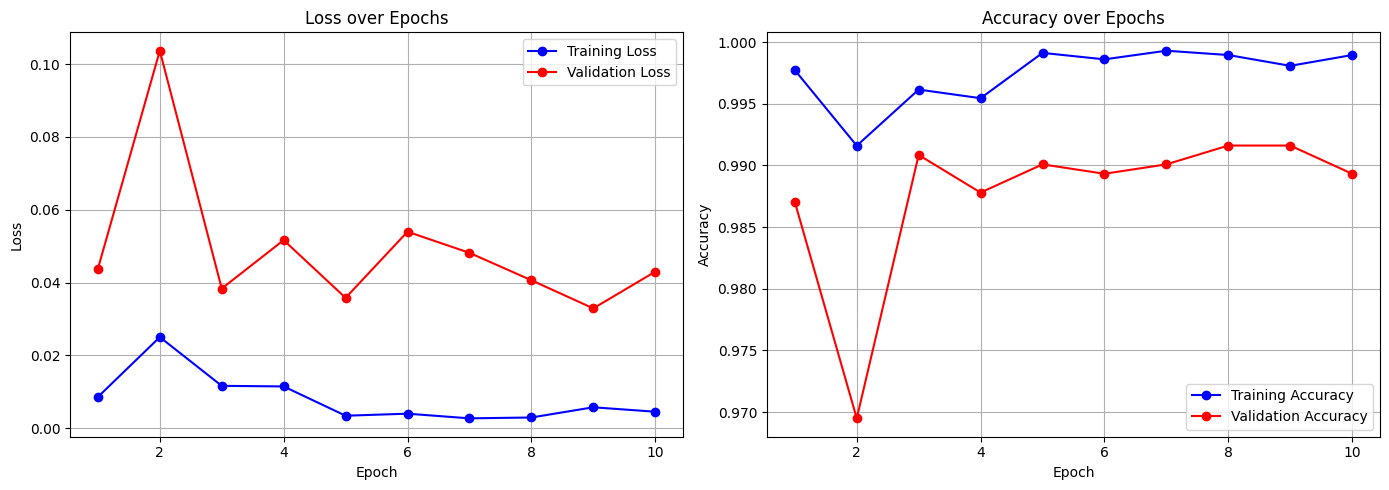

In [19]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


              precision    recall  f1-score   support

      glioma       1.00      0.97      0.99       300
  meningioma       0.97      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



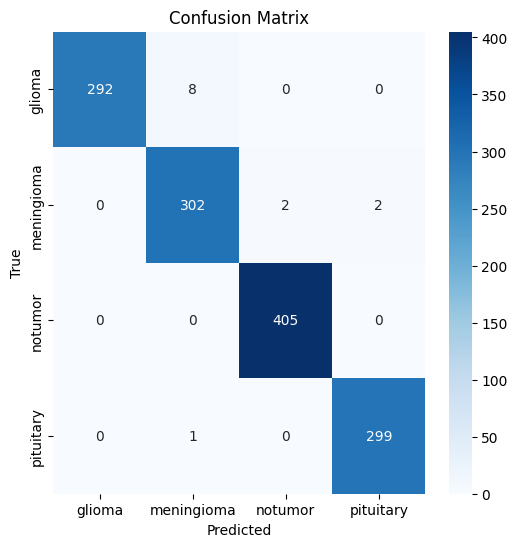

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()